# ECU Floods

Notebook to compare flash flood risk in Ecuador

In [1]:
#### Dependencies
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from rasterstats import zonal_stats, gen_zonal_stats
from glob import glob
import matplotlib.pyplot as plt
import shapely

In [2]:
# open polys
DATA_PATH = '/Users/cascade/Github/PopGridCompare/data/'

In [3]:
#### Functions
def zone_loop(polys_in, rst_list, stats_type, col, split):
    """ Function loops through rasters, calcs zonal_stats and returns stats as a data frame.
    Args:
        polys_in = polygons
        rst_list = list of paths & fns of rasters
        stats_type = stats type for each poly gone (see zonal stats)
        col = column to merge it all
        split = where to split the file name string (e.g. _matched.tif)
    """
    
    # copy polys to write out
    polys_out = polys_in.copy()
    
    for rst in rst_list:
        
        # Get data name
        data = rst.split(DATA_PATH+'interim/')[1].split(split)[0]
        print('Started', data)
        
        # Run zonal stats
        zs_feats = zonal_stats(polys_in, rst, stats=stats_type, geojson_out=True)
        zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=polys_in.crs)
        
        # Rename columns and merge
        zgdf = zgdf.rename(columns={stats_type: data+'_'+stats_type})
        
        polys_out = polys_out.merge(zgdf[[col, data+'_'+stats_type]], on = col, how = 'inner')
    
    return polys_out

In [4]:
def poly_prep(polys_fn, col):
    "function opens earth quake polygons for zonal loop"
    
    # open
    polys = gpd.read_file(polys_fn)
    
    # subset 
    polys = polys[['geometry', col]]
    
    #UID
    ids = ['UID'+str(x) for x in list(range(0,len(polys)))]
    
    polys['UID'] = ids
    
    return polys

## Flood risk All

In [5]:
# Git tif files
rst_fns = sorted(glob('/Users/cascade/Github/PopGridCompare/data/interim/*all_ECU.tif'))
rst_fns

['/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_all_ECU.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GHS15_all_ECU.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_all_ECU.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/LS15_all_ECU.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/WP16_all_ECU.tif']

In [6]:
# Open flood susceptability layer
ecu_fn = DATA_PATH+'raw/ECU-Floods/Susceptibility/FF_suscept_PCA.shp'
col = 'suscPCA_cl' # catagories 
ecu_polys = poly_prep(ecu_fn, col)

In [7]:
# Need to reproject crs to epsg:4326
ecu_polys = ecu_polys.to_crs('epsg:4326')


In [8]:
# Run zonal stats loop
col = 'UID'
ecu_all_sum = zone_loop(ecu_polys, rst_fns, 'sum', col, '_all_ECU.tif')

Started ESRI16
Started GHS15
Started GPWv4
Started LS15
Started WP16


In [9]:
ecu_all_sum

,geometry,suscPCA_cl,UID,ESRI16_sum,GHS15_sum,GPWv4_sum,LS15_sum,WP16_sum
0,"POLYGON ((-79.37915 1.06458, -79.37535 1.06841...",4,UID0,311.0,1417.930309,586.389954,4086.0,1924.792725
1,"MULTIPOLYGON (((-78.95000 1.21667, -78.94879 1...",3,UID1,7018.0,7077.026305,8134.629883,9829.0,9643.500000
2,"POLYGON ((-78.95000 1.21667, -78.95225 1.21614...",2,UID2,11395.0,965.884866,8365.265625,8633.0,14422.357422
3,"POLYGON ((-78.87917 1.31250, -78.87855 1.34800...",2,UID3,10674.0,30658.750976,17958.470703,21479.0,16091.611328
4,"POLYGON ((-80.26731 -3.00865, -80.26602 -2.964...",1,UID4,3230.0,1350.988527,2577.003418,962.0,1832.885742
...,...,...,...,...,...,...,...,...
1898,"POLYGON ((-77.13333 -1.14167, -77.12083 -1.141...",5,UID1898,NaN,NaN,NaN,113.0,124.480164
1899,"POLYGON ((-78.79166 -1.22083, -78.79131 -1.214...",9,UID1899,6636.0,18568.724618,16165.535156,8329.0,9902.400391
1900,"POLYGON ((-77.54167 -1.55417, -77.54167 -1.550...",5,UID1900,NaN,NaN,NaN,142.0,NaN
1901,"POLYGON ((-78.29640 -2.39925, -78.29223 -2.393...",8,UID1901,762.0,311.943406,3163.505859,464.0,2650.011963


In [10]:
# Save it out
fn_out = DATA_PATH+'interim/ECU-Flood-Risk_all.shp'
ecu_all_sum.to_file(fn_out)

## Flood risk rural

In [11]:
# Git tif files
rst_fns = sorted(glob('/Users/cascade/Github/PopGridCompare/data/interim/*rural_ECU.tif'))
rst_fns

['/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_rural_ECU.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GHS15_rural_ECU.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_rural_ECU.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/LS15_rural_ECU.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/WP16_rural_ECU.tif']

In [12]:
# Run zonal stats loop
col = 'UID'
ecu_rural_sum = zone_loop(ecu_polys, rst_fns, 'sum', col, '_rural_ECU.tif')

Started ESRI16
Started GHS15
Started GPWv4
Started LS15
Started WP16


In [13]:
# Save it out
fn_out = DATA_PATH+'interim/ECU-Flood-Risk_rural.shp'
ecu_rural_sum.to_file(fn_out)

## Flood risk urban

In [14]:
# Git tif files
rst_fns = sorted(glob('/Users/cascade/Github/PopGridCompare/data/interim/*urban_ECU.tif'))
rst_fns

['/Users/cascade/Github/PopGridCompare/data/interim/ESRI16_urban_ECU.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GHS15_urban_ECU.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/GPWv4_urban_ECU.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/LS15_urban_ECU.tif',
 '/Users/cascade/Github/PopGridCompare/data/interim/WP16_urban_ECU.tif']

In [15]:
# Run zonal stats loop
col = 'UID'
ecu_urban_sum = zone_loop(ecu_polys, rst_fns, 'sum', col, '_urban_ECU.tif')

Started ESRI16
Started GHS15
Started GPWv4
Started LS15
Started WP16


In [16]:
# Save it out
fn_out = DATA_PATH+'interim/ECU-Flood-Risk_urban.shp'
ecu_urban_sum.to_file(fn_out)

## Make Plots

In [135]:
def bar_plot(df, col, off_set, a_v, bar_color, scale, pattern = None):
    """ Make a custom bar plots
    Args: 
        df = data frame to plot
        col = name of col to plot
        off_set = off_set of bar as float
        a_v = alpha 
        bar_color = color as string
        hatch = type, default is none
    """
    
    # Plot
    data = df[df['suscPCA_cl'] == 1][col].sum()
    a = plt.bar(1+off_set, data / scale, width=0.12, align='center', alpha  = a_v, color = bar_color, ec = None,  hatch = pattern)
    data = df[df['suscPCA_cl'] == 2][col].sum()
    b = plt.bar(2+off_set, data / scale, width=0.12, align='center', alpha  = a_v, color = bar_color, ec = None,  hatch = pattern)
    data = df[df['suscPCA_cl'] == 3][col].sum()
    c = plt.bar(3+off_set, data / scale, width=0.12, align='center', alpha  = a_v, color = bar_color, ec = None,  hatch = pattern)
    data = df[df['suscPCA_cl'] == 4][col].sum()
    d = plt.bar(4+off_set, data / scale, width=0.12, align='center', alpha  = a_v, color = bar_color, ec = None,  hatch = pattern)
    data = df[df['suscPCA_cl'] == 5][col].sum()
    d = plt.bar(5+off_set, data / scale, width=0.12, align='center', alpha  = a_v, color = bar_color, ec = None,  hatch = pattern)
    data = df[df['suscPCA_cl'] == 6][col].sum()
    d = plt.bar(6+off_set, data / scale, width=0.12, align='center', alpha  = a_v, color = bar_color, ec = None,  hatch = pattern)
    data = df[df['suscPCA_cl'] == 7][col].sum()
    d = plt.bar(7+off_set, data / scale, width=0.12, align='center', alpha  = a_v, color = bar_color, ec = None,  hatch = pattern)
    data = df[df['suscPCA_cl'] == 8][col].sum()
    d = plt.bar(8+off_set, data / scale, width=0.12, align='center', alpha  = a_v, color = bar_color, ec = None,  hatch = pattern)
    data = df[df['suscPCA_cl'] == 9][col].sum()
    d = plt.bar(9+off_set, data / scale, width=0.12, align='center', alpha  = a_v, color = bar_color, ec = None,  hatch = pattern)
    data = df[df['suscPCA_cl'] == 10][col].sum()
    d = plt.bar(10+off_set, data / scale, width=0.12, align='center', alpha  = a_v, color = bar_color, ec = None,  hatch = pattern)


In [66]:
# #### set colors
ESRI16_c = 'blue'
GHS15_c = 'indigo'
GPWv4_c = 'deeppink'
LS15_c = 'deepskyblue'
WP16_c = 'forestgreen'

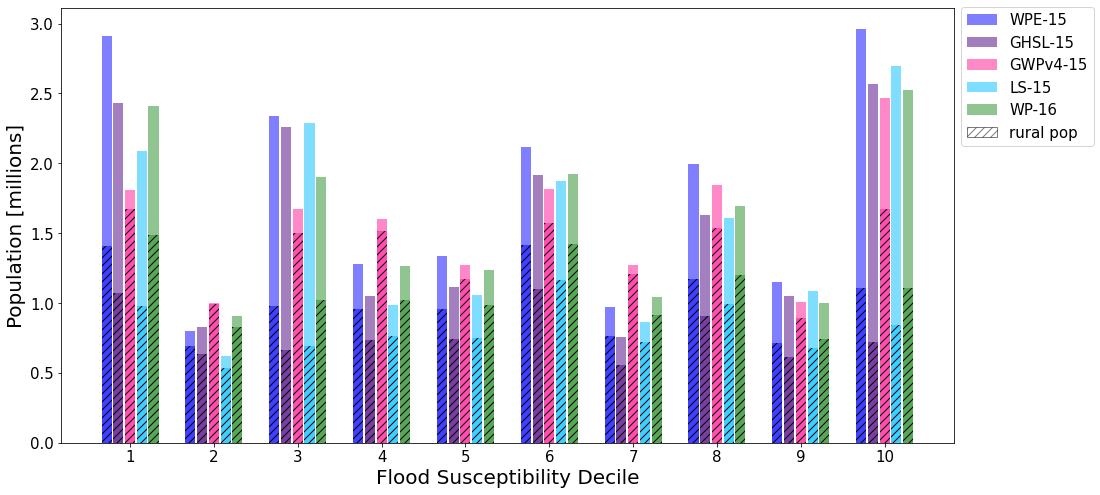

In [171]:
# # Make bar plot 
fig, axs = plt.subplots(1, 1, figsize = (16, 8), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)
scale_data = 10**6

# plots all 
bar_plot(df= ecu_all_sum, col= 'ESRI16_sum', off_set = -.28, a_v = 0.5, bar_color = ESRI16_c, scale = scale_data, pattern = None)
bar_plot(df= ecu_all_sum, col= 'GHS15_sum', off_set = -.14, a_v = 0.5, bar_color = GHS15_c, scale = scale_data, pattern = None)
bar_plot(df= ecu_all_sum, col= 'GPWv4_sum', off_set = 0, a_v = 0.5, bar_color = GPWv4_c, scale = scale_data, pattern = None)
bar_plot(df= ecu_all_sum, col= 'LS15_sum', off_set = .14, a_v = 0.5, bar_color = LS15_c, scale = scale_data, pattern = None)
bar_plot(df= ecu_all_sum, col= 'WP16_sum', off_set = .28, a_v = 0.5, bar_color = WP16_c, scale = scale_data, pattern = None)

# plots rural 
bar_plot(df= ecu_rural_sum, col= 'ESRI16_sum', off_set = -.28, a_v = 0.5, bar_color = ESRI16_c, scale = scale_data, pattern = '///')
bar_plot(df= ecu_rural_sum, col= 'GHS15_sum', off_set = -.14, a_v = 0.5, bar_color = GHS15_c, scale = scale_data, pattern = '///')
bar_plot(df= ecu_rural_sum, col= 'GPWv4_sum', off_set = 0, a_v = 0.5, bar_color = GPWv4_c, scale = scale_data, pattern = '///')
bar_plot(df= ecu_rural_sum, col= 'LS15_sum', off_set = .14, a_v = 0.5, bar_color = LS15_c, scale = scale_data, pattern = '///')
bar_plot(df= ecu_rural_sum, col= 'WP16_sum', off_set = .28, a_v = 0.5, bar_color = WP16_c, scale = scale_data, pattern = '///')

# # Labels
axs.set_title(title, size = 20 )
axs.set_xlabel('Flood Susceptibility Decile', fontsize = 20)
axs.set_ylabel('Population [millions]', fontsize = 20)

# ticks
plt.xticks(list(range(1,11)), fontsize = 15);
plt.yticks(fontsize = 15);

# legend
legend_elements = [Patch(facecolor=ESRI16_c, alpha = 0.5, edgecolor=None, label='WPE-15'),
                  Patch(facecolor=GHS15_c, alpha = 0.5, edgecolor=None, label='GHSL-15'),
                  Patch(facecolor=GPWv4_c, alpha = 0.5, edgecolor=None, label='GWPv4-15'),
                  Patch(facecolor=LS15_c, alpha = 0.5, edgecolor=None, label='LS-15'),
                  Patch(facecolor= WP16_c, alpha = 0.5, edgecolor=None, label='WP-16'),
                  Patch(facecolor= 'white', alpha = 0.5,  hatch = '///', edgecolor='black', label='rural pop')]
plt.legend(handles = legend_elements, bbox_to_anchor=(1, 1.02), loc='upper left', ncol=1, fontsize = 15);

#save it out
fig_out = '/Users/cascade/Github/PopGridCompare/data/FIGS/MS/Finalv1/Fig6.png'
plt.savefig(fig_out, dpi = 300, facecolor = 'white', bbox_inches='tight')

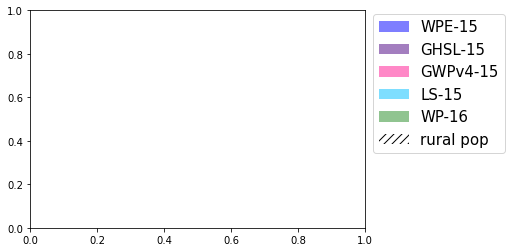

In [169]:
# legend
legend_elements = [Patch(facecolor=ESRI16_c, alpha = 0.5, edgecolor=None, label='WPE-15'),
                  Patch(facecolor=GHS15_c, alpha = 0.5, edgecolor=None, label='GHSL-15'),
                  Patch(facecolor=GPWv4_c, alpha = 0.5, edgecolor=None, label='GWPv4-15'),
                  Patch(facecolor=LS15_c, alpha = 0.5, edgecolor=None, label='LS-15'),
                  Patch(facecolor= WP16_c, alpha = 0.5, edgecolor=None, label='WP-16'),
                  Patch(facecolor= 'white', alpha = 0.5,  hatch = '///', edgecolor=None, label='rural pop')]
plt.legend(handles = legend_elements, bbox_to_anchor=(1, 1.02), loc='upper left', ncol=1, fontsize = 15);

In [100]:
# def make_data(df, col):
#     "make data for plotting"
#     out = df[['suscPCA_cl',col]].groupby('suscPCA_cl').sum().reset_index()
#     return out

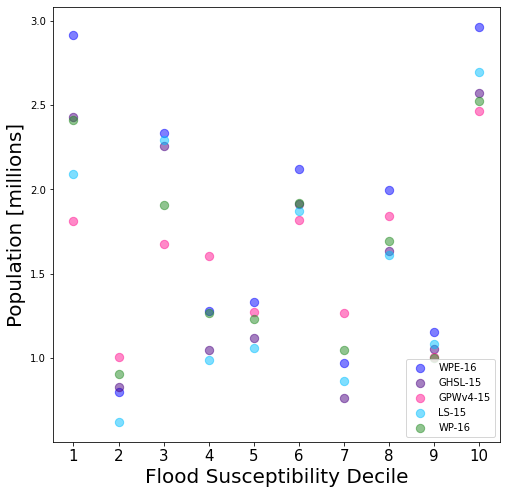

In [112]:
# # plot it for all 
# title = ''
# scale = 10**6

# # set up
# fig, axs = plt.subplots(1, 1, figsize = (8, 8), sharex=True)
# ws = 0.25
# fig.subplots_adjust(wspace=ws)

# # plots 
# data = make_data(ecu_all_sum, 'ESRI16_sum')
# axs.scatter(data['suscPCA_cl'], data['ESRI16_sum'] / scale, color = ESRI16_c, alpha = 0.5, s = 70)
# data = make_data(ecu_all_sum, 'GHS15_sum')
# axs.scatter(data['suscPCA_cl'], data['GHS15_sum'] / scale, color = GHS15_c, alpha = 0.5, s = 70)
# data = make_data(ecu_all_sum, 'GPWv4_sum')
# axs.scatter(data['suscPCA_cl'], data['GPWv4_sum'] / scale, color = GPWv4_c,  alpha = 0.5, s = 70)
# data = make_data(ecu_all_sum, 'LS15_sum')
# axs.scatter(data['suscPCA_cl'], data['LS15_sum'] / scale, color = LS15_c, alpha = 0.5, s = 70)
# data = make_data(ecu_all_sum, 'WP16_sum')
# axs.scatter(data['suscPCA_cl'], data['WP16_sum'] / scale, color = WP16_c, alpha = 0.5, s = 70)

# # Labels
# axs.set_title(title, size = 20 )
# axs.set_xlabel('Flood Susceptibility Decile', fontsize = 20)
# axs.set_ylabel('Population [millions]', fontsize = 20)

# # tics
# #ticks_bar = ['< 0.4', '0.4 to 0.5', ' 0.5 to 0.6', '>= 0.6']
# plt.xticks(list(range(1,11)), fontsize = 15)
# #plt.yticks(fontsize = 15)

# labels = ['WPE-16', 'GHSL-15', 'GPWv4-15', 'LS-15', 'WP-16']
# plt.legend(labels)

# save it out
# fig_out = '/Users/cascade/Github/PopGridCompare/data/FIGS/MS/Finalv1/Nepal2015_all.png'
# plt.savefig(fig_out, dpi = 300, facecolor = 'white', bbox_inches='tight')

In [18]:
# #### set colors
# ESRI16_c = 'blue'
# GHS15_c = 'indigo'
# GPWv4_c = 'deeppink'
# LS15_c = 'deepskyblue'
# WP16_c = 'forestgreen'

In [19]:
# # Make bar plot 
# fig, axs = plt.subplots(1, 1, figsize = (12, 8), sharex=True)
# ws = 0.25
# fig.subplots_adjust(wspace=ws)
# scale_data = 10**6

# # Fake rural for legend
# f = bar_plot(ecu_rural_out, 'ESRI16_sum', -0.3, 0.5, 'white',  scale_data, '///')

# # All data
# a = bar_plot(ecu_all_out, 'ESRI16_sum', -0.3, 0.5, ESRI16_c, scale_data, None)
# b = bar_plot(ecu_all_out, 'GHS15_sum', -0.15, 0.6, GHS15_c, scale_data, None)
# c = bar_plot(ecu_all_out, 'GPWv4_sum', 0, 0.7, GPWv4_c, scale_data, None)
# d = bar_plot(ecu_all_out, 'LS15_sum', 0.15, 0.8, LS15_c, scale_data, None)
# e = bar_plot(ecu_all_out, 'WP16_sum', 0.3, 0.9, WP16_c, scale_data, None)

# # Rural
# bar_plot(ecu_rural_out, 'ESRI16_sum', -0.3, 0.5, ESRI16_c,  scale_data, '///')
# bar_plot(ecu_rural_out, 'GHS15_sum', -0.15,  0.6, GHS15_c,  scale_data, '///')
# bar_plot(ecu_rural_out, 'GPWv4_sum', 0,  0.7, GPWv4_c,  scale_data,'///')
# bar_plot(ecu_rural_out, 'LS15_sum', 0.15,  0.8, LS15_c, scale_data, '///')
# bar_plot(ecu_rural_out, 'WP16_sum', 0.3,  0.9, WP16_c,  scale_data,'///')

# # # Fake rural for legend
# # f = bar_plot(ecu_rural_out, 'ESRI16_sum', -0.3,0.0, ESRI16_c,  scale_data, '///')

# # tics
# ticks_bar = ['< 0.4', '0.4 to 0.5', ' 0.5 to 0.6', '>= 0.6']
# plt.xticks([1,2,3,4], ticks_bar, fontsize = 15)
# plt.yticks(fontsize = 15)

# leg = [a[0],b[0],c[0],d[0],e[0], f[0]]
# leg_labels = ['WPE-16', 'GHSL-15', 'GPWv4-15', 'LS-15', 'WP-16', 'rural pop']
# plt.legend(leg, leg_labels, fontsize = 15)

# # Labels / Titles
# axs.set_title('Flash Floods Susceptibility', size = 20)
# axs.set_xlabel('', fontsize = 15)
# axs.set_ylabel('Total Population [millions]', fontsize = 15)

# # save it out
# fig_out = '/Users/cascade/Github/PopGridCompare/data/FIGS/MS/Fig5-ecu.png'
# plt.savefig(fig_out, dpi = 300, facecolor = 'white', bbox_inches='tight')

### Risks out

In [20]:
# # Save out by risk layer
# r = 4
# fn_out = DATA_PATH+'interim/ECU-Flood-Risk_all_r'+str(r)+'.shp'
# out = ecu_all_out[ecu_all_out['risk']== r]
# out.to_file(fn_out)